In [21]:
### Init network Build
import numpy as np
from pathlib import Path
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
print(tf.__version__, 'tf')
print(keras.__version__, 'keras')


2.3.0 tf
2.4.3 keras


In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16691219777139407371
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16531217851662057450
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15625908257045308047
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11141855360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10716844164584153391
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [23]:
#2.4.1 tf
#2.4.3 keras

In [24]:
#!nvidia-smi
#12169 - 13000

In [25]:
from google.cloud import storage
# create a service key json file and point to it here,   I will put a copy of the .json key I am using in slack.
storage_client = storage.Client.from_service_account_json('access_key1.json')  # create a service key json file and point to it here

bucket_name = 'pollutemenot-ai'
bucket = storage_client.get_bucket(bucket_name)

In [27]:
#download files
t0 = time.time()
prefix = 'GEE_images_final2/'
dl_dir = '/data/image_final2/'
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    filename = blob.name.replace('/', '_') 
    if Path(dl_dir + filename).is_file(): 
        print('r', end = '\r')
        continue  # this file is already downloaded so skip download
    else:
        try:
            blob.download_to_filename(dl_dir + filename)  # Download
            print('+', end = '')
        except:
            print('error, waiting 5sec and trying again.')
            time.sleep(5)
            blob.download_to_filename(dl_dir + filename)  # Download
            print('+', end = '')
print('finished in ', (time.time()-t0)/60, 'minutes.')

finished in  4.799818980693817 minutes.


In [9]:
dl_dir = '/data/rad1/'

tif_list = [f for f in Path(dl_dir).iterdir() if '.tif' in str(f)]
print(len(tif_list))
#tif_list 15321

11


In [3]:
datapath = "Madhukar/Data_combined_regular_clean.csv"
df_labels = pd.read_csv(datapath, encoding = "ISO-8859-1")
df_labels.head()#.iloc[99]
df_labels = df_labels[['da_number', 'cwa_determination']]
print(df_labels.shape)
df_labels.head()

(14619, 2)


,da_number,cwa_determination
0,LRB-1983-10120,0
1,LRB-1985-69031,1
2,LRB-1986-99614,1
3,LRB-1990-97632,1
4,LRB-1991-98611,1


In [86]:
def create_image_lookup(tiff_image_list):
    
    t0 = time.time()
    list_rows = []
    for v in tiff_image_list:
        #print(v)
        nl = v.name.split('_')[3:7]
        nl.append(v)
        #print(nl)
        list_rows.append(nl)
    columns = ['img_res', 'img_type', 'img_index', 'da_num', 'img_path']
    df = pd.DataFrame(list_rows, columns = columns)
    print('dataframe shape:', df.shape)
    print('seconds taken:', time.time()-t0)
    return df
df = create_image_lookup(tif_list)
df.head()

dataframe shape: (11, 5)
seconds taken: 0.0016570091247558594


,img_res,img_type,img_index,da_num,img_path
0,hires,RGB,9003,SAC-2017-00920,/data/rad1/Rad_Experiment_1_hires_RGB_9003_SAC...
1,hires,RGB,9009,SAC-2017-00939,/data/rad1/Rad_Experiment_1_hires_RGB_9009_SAC...
2,hires,RGB,9004,SAC-2017-00927,/data/rad1/Rad_Experiment_1_hires_RGB_9004_SAC...
3,hires,RGB,9005,SAC-2017-00931,/data/rad1/Rad_Experiment_1_hires_RGB_9005_SAC...
4,hires,RGB,9001,SAC-2017-00917,/data/rad1/Rad_Experiment_1_hires_RGB_9001_SAC...


In [84]:
p = gdal.Open(str(df.img_path.iloc[0]))
channels = p.RasterCount
print(channels)
#print(dir(p))
print(p.GetDescription())

# iterate through rasters and add each to the list of layer_list
layer_list = [np.array(p.GetRasterBand(i).ReadAsArray()) for i in range(1,4)] 

12
/data/rad1/Rad_Experiment_1_hires_RGB_9003_SAC-2017-00920_RGB_hires.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


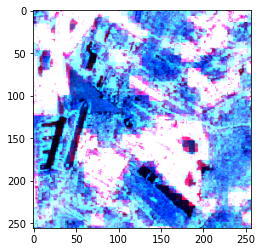

In [85]:
fig, ax = plt.subplots()
img = np.array(layer_list).swapaxes(0,2)
ax.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8920 1


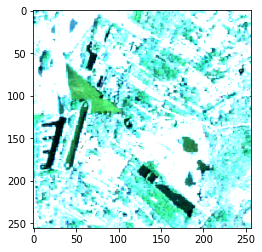

In [77]:
fig, ax = plt.subplots()
i_arr = create_array(df.img_path.iloc[0])
#i_arr = i_arr.reshape(256,256,12)
i_arr = i_arr.swapaxes(0,2)
#for chan in range(1,4):
#    i_arr[:,:,chan] = i_arr[:,:,chan] / np.max(i_arr[:,:,chan])
rgb_imag = i_arr[:,:,1:4]

print(np.max(rgb_imag), np.min(rgb_imag))
ax.imshow(rgb_imag)


In [11]:
print(df.shape)
df[~df.da_num.str.contains('-')].shape

(87647, 5)


(2746, 5)

In [10]:
df_merged = pd.merge(df, df_labels, left_on = 'da_num', right_on = 'da_number', how = 'left')
print(df_merged.shape)
df_merged.head()

(64788, 7)


,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1.0
1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0.0
2,lores,gmndwi,5824,NAN-2016-00095-USH,/data/image_final2/GEE_images_final2_lores_gmn...,NAN-2016-00095-USH,0.0
3,hires,srtm,1436,LRL-2016-00917-htm,/data/image_final2/GEE_images_final2_hires_srt...,LRL-2016-00917-htm,0.0
4,lores,gmndwi,459,LRC-2016-00332,/data/image_final2/GEE_images_final2_lores_gmn...,LRC-2016-00332,0.0


In [11]:
def create_array(tif_image):
    try:
        p = gdal.Open(str(tif_image))
        channels = p.RasterCount

        # iterate through rasters and add each to the list of layer_list
        layer_list = [np.array(p.GetRasterBand(i).ReadAsArray()) for i in range(1,channels+1)] 
    except: 
        print("Error with image:", tif_image)
        return np.nan
    return np.array(layer_list)
create_array('/data/image_final2/GEE_images_final2_hires_mndwi_2105_MVK-2016-00239-LCM_mndwi_hires.tif').shape

(1, 256, 256)

In [14]:
def get_image_metrics(image_path):
    image_arr = create_array(image_path)
    mean_pixel_value = np.nanmean(image_arr)
    std_pixel_value = np.nanstd(image_arr)
    return mean_pixel_value, std_pixel_value

In [18]:
df_merged['metrics'] = df_merged.img_path.apply(get_image_metrics)
df_merged.head()

Error with image: /data/image_final2/GEE_images_final2_lores_srtm_5857_NAN-2016-01232-USH_srtm_lores.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Error with image: /data/image_final2/GEE_images_final2_hires_mndvi_8236_SAC-2012-00032_mndvi_hires.tif
Error with image: /data/image_final2/GEE_images_final2_hires_mndvi_6176_NAO-2016-01643-tca_mndvi_hires.tif
Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif
Error with image: /data/image_final2/GEE_images_final2_lores_gmndwi_8029_POA-2019-00608_gmndwi_lores.tif
Error with image: /data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif


,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1.0,"(-0.3306894463763968, 0.09898692070930509)"
1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0.0,"(-0.40988840562690426, 0.19788100896017022)"
2,lores,gmndwi,5824,NAN-2016-00095-USH,/data/image_final2/GEE_images_final2_lores_gmn...,NAN-2016-00095-USH,0.0,"(0.56878513, 0.23097283)"
3,hires,srtm,1436,LRL-2016-00917-htm,/data/image_final2/GEE_images_final2_hires_srt...,LRL-2016-00917-htm,0.0,"(266.44921875, 1.7671324110003224)"
4,lores,gmndwi,459,LRC-2016-00332,/data/image_final2/GEE_images_final2_lores_gmn...,LRC-2016-00332,0.0,"(0.6707717, 0.15186259)"


In [19]:
df_merged.to_csv('image_metrics_030421.csv')

In [11]:
img_sum_list = []
for da, dadf in df.groupby('da_num'):
    img_sum_list.append(dadf.shape[0])
    if dadf.shape[0] != 10: print(dadf.shape)
len([x for x in img_sum_list if x != 10])

(9, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(9, 5)
(9, 5)
(7, 5)
(7, 5)
(7, 5)
(6, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(9, 5)
(9, 5)
(7, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(7, 5)
(8, 5)
(8, 5)
(7, 5)
(8, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(9, 5)
(1, 5)
(1, 5)
(1, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)

248

In [13]:
#fig, ax = plt.subplots(4,5, figsize = (20,19))
#axes = [(x,y) for x in range(4) for y in range(5)]
#print(axes)

processing hires gmndwi // elapsed time 0.504 sec
processing hires mndvi // elapsed time 29.571 sec
processing hires mndwi // elapsed time 71.396 sec
processing hires seasonality // elapsed time 112.399 sec
processing hires srtm // elapsed time 121.03 sec
Error with image: /data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


processing hires transition // elapsed time 134.008 sec
processing lores gmndwi // elapsed time 142.826 sec
Error with image: /data/image_final2/GEE_images_final2_lores_gmndwi_8029_POA-2019-00608_gmndwi_lores.tif
processing lores mndvi // elapsed time 172.789 sec
processing lores mndwi // elapsed time 213.833 sec
processing lores srtm // elapsed time 255.407 sec


2201

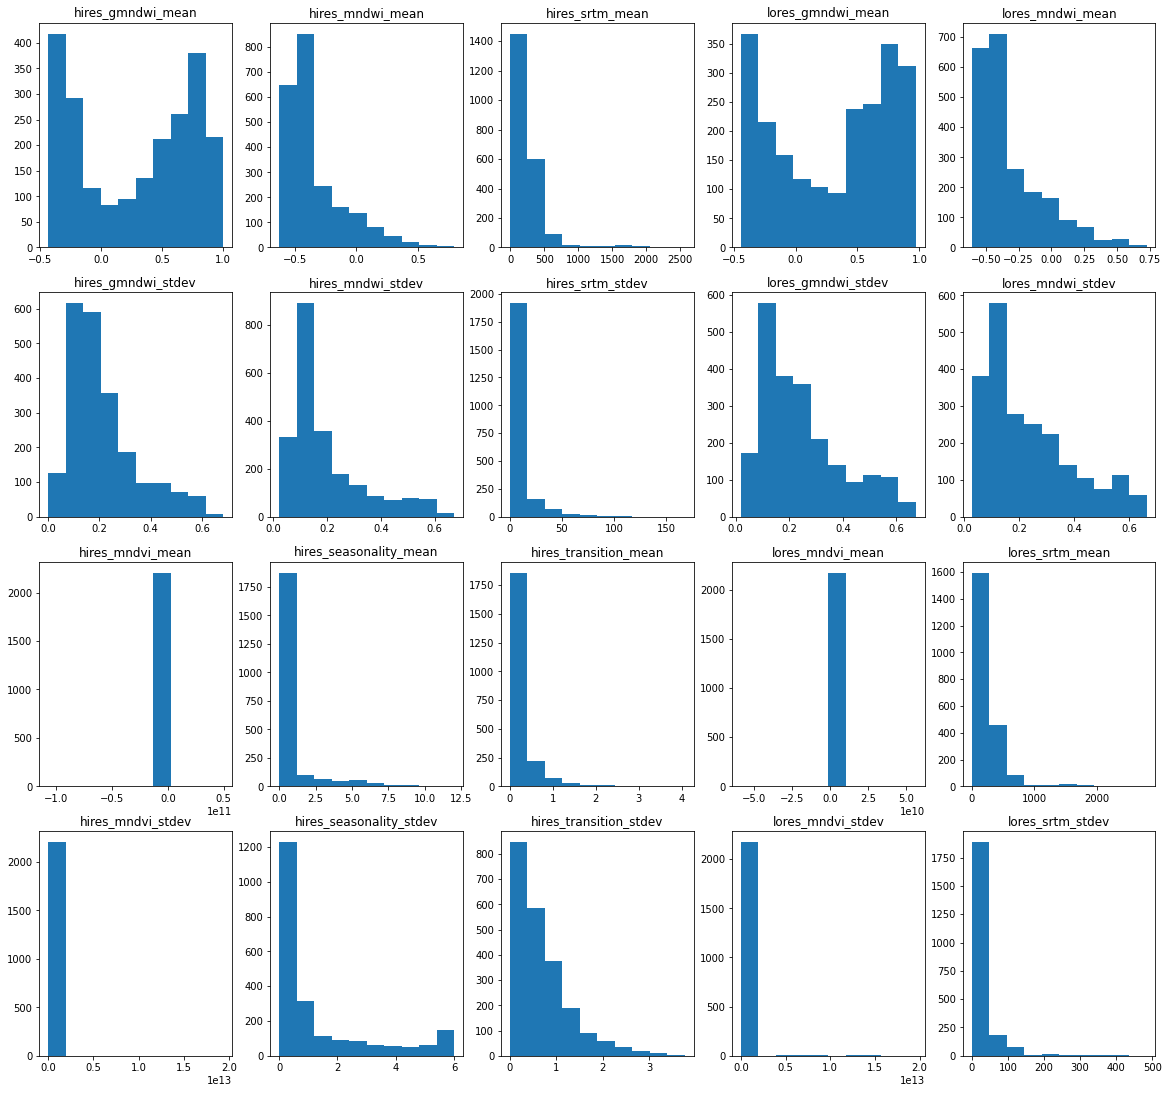

In [11]:
t0 = time.time()
fig, ax = plt.subplots(4,5, figsize = (20,19))
i = 0 
axes = [(x,y) for y in range(5) for x in range(4)]
for res, resdf in df.groupby('img_res'):
    for it, itdf in resdf.groupby('img_type'):
        print('processing', res, it, r'// elapsed time', round(time.time()-t0,3), 'sec')
        image_series = itdf.img_path.apply(create_array)
        mean_pixel_value = image_series.apply(lambda x: np.nanmean(x))
        std_pixel_value = image_series.apply(lambda x: np.nanstd(x))
        ax[axes[i]].hist(mean_pixel_value)
        ax[axes[i]].set_title(res + '_' + it + '_mean')
        i += 1
        ax[axes[i]].hist(std_pixel_value)
        ax[axes[i]].set_title(res + '_' + it + '_stdev')
        i += 1
#        break
#    break
len(image_series)

In [118]:
layer_setup = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm'], ['lores', 'gmndwi'], ['lores', 'mndvi'], ['lores', 'srtm']]

In [12]:
tif_image = '/data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif'

p = gdal.Open(str(tif_image))
print(p, type(p))
channels = p.RasterCount

# iterate through rasters and add each to the list of layer_list
layer_list = [np.array(p.GetRasterBand(i).ReadAsArray()) for i in range(1,channels+1)] 

None <class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'RasterCount'

In [147]:
print(df_merged.shape)
df_merged = df_merged[~(df_merged['da_num'] == 'POA-2019-00608')]
print(df_merged.shape)

(20090, 7)
(20080, 7)


In [148]:
def packager1(df_lookup, layer_setup):
    t0 = time.time()
    X = []
    y = []
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images.")
            continue
            
        else:
            stacked_images = []
            for channel in layer_setup:
                image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                #print(image_row, type(image_row))
                if image_row.shape[0] != 1: 
                    print('Duplicates?', image_row)
                stacked_images.append(create_array(image_row.img_path.iloc[0]))
            X.append(np.array(stacked_images).reshape(1,256,256,len(layer_setup)))
            
            y.append(ddf.cwa_determination.iloc[0])
            # break
    print(len(y), 'training examples prepared in', round(time.time()-t0), 'sec')
    return np.concatenate(X), np.array(y)
    
    
X, y = packager1(df_merged, layer_setup)
print(X.shape, y.shape)

LRB-2004-00299 error, not 10 images.
LRC-2012-00698 error, not 10 images.
LRH-2015-00966-BCR error, not 10 images.
LRH-2018-00971-GUY error, not 10 images.
LRH-2020-00057-SCR error, not 10 images.
MVN-2015-00044-SR error, not 10 images.
MVN-2015-00919-SQ error, not 10 images.
MVN-2019-00883-SL error, not 10 images.
MVP-2008-04451-WAB error, not 10 images.
MVP-2016-02261-RJH error, not 10 images.
NAO-2016-00437-tca error, not 10 images.
NAO-2020-00781-bcd error, not 10 images.
NAP-2010-00830-67 error, not 10 images.
NWO-2016-01637-BIS error, not 10 images.
NWO-2016-02128-BIS error, not 10 images.
NWO-2017-00021-BIS error, not 10 images.
NWO-2019-00281-DEN error, not 10 images.
NWS-2016-00994 error, not 10 images.
POH-2011-00296-RD9 error, not 10 images.
SAW-2019-00663 error, not 10 images.
1995 training examples prepared in 81 sec
(1995, 256, 256, 6) (1995,)


In [166]:
## develop input splitter
from keras.applications.vgg16 import VGG16
vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model1.trainable = False
vgg16_model2.trainable = False

print(type(vgg16_model1))
vgg16_model1.summary()

<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
________________________________________________________________

In [5]:
test_input = np.random.rand(256,256,3)
test_input = test_input.reshape(1, 256,256, 3)
print(test_input.shape)
vgg16_model1.predict(test_input)

(1, 256, 256, 3)


array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.88731253, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.079706  , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.4023306 , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.089556  , 0.        ],
         [0.06538105, 0.        , 0.        , ..., 0.1947375 ,
          1.0068531 , 0.        ],
         [0.        , 0.        , 0.02785492, ..., 0.        ,
          0.9805566 , 0.        ]],

        [[0.04000388, 0.        , 0.        , ..., 0.        ,
          0.89269316, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.2469203 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.5314772 , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.1317878 , 0. 

In [24]:
for i in range(2):
    s = np.random.rand(256,256,6)[:,:, i*3:3*(i+1)].shape
    print(s)

(256, 256, 3)
(256, 256, 3)


In [179]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax
from keras.models import Model, Sequential

num_channels = 6
input = Input(shape=(256,256, num_channels))

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0,3]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input)
    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    else: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    print(out.shape)
    out = Dense(10)(out)
    print(out.shape)
    out = Flatten()(out)
    print(out.shape)
    branch_outputs.append(out)

# Concatenating the branches outputs:
out = Concatenate()(branch_outputs)
print(out.shape)

# Add final dense layers and softmax
out = Dense(10)(out)
print(out.shape)
out = Dense(6)(out)
out = Dense(2)(out)
print(out.shape)
out = Softmax()(out)
print(out.shape)

(None, 256, 256, 6)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 256, 256, 6)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 1280)
(None, 10)
(None, 2)
(None, 2)


In [175]:
!nvidia-smi

Mon Mar  1 00:06:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    59W / 149W |  10868MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [180]:
model = Model(inputs=input, outputs=out)   
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 8, 8, 512)    14714688    lambda_12[0][0]                  
_______________________________________________________________________________________

In [181]:
predicts = model.predict(X)

In [18]:
predicts

array([[0.52614987, 0.47385013],
       [0.50729644, 0.49270362],
       [0.4020764 , 0.59792364],
       [0.5092877 , 0.49071234],
       [0.558615  , 0.44138497],
       [0.5424467 , 0.4575533 ],
       [0.6158485 , 0.38415152],
       [0.9279001 , 0.07209992],
       [0.91072845, 0.08927153],
       [0.7216913 , 0.27830866],
       [0.69085824, 0.30914176],
       [0.6877592 , 0.31224078],
       [0.49993137, 0.50006866],
       [0.6228172 , 0.37718278],
       [0.79717696, 0.20282304],
       [0.57873434, 0.4212657 ],
       [0.6701145 , 0.32988548],
       [0.4465543 , 0.5534457 ],
       [0.47780797, 0.522192  ],
       [0.6321457 , 0.3678543 ],
       [0.4218403 , 0.5781597 ],
       [0.7781874 , 0.22181265],
       [0.50960356, 0.49039644],
       [0.51452   , 0.48548   ],
       [0.47596624, 0.5240337 ],
       [0.60892016, 0.39107987],
       [0.6190333 , 0.38096675],
       [0.76610214, 0.23389782],
       [0.64370394, 0.35629612],
       [0.46383935, 0.5361606 ],
       [0.

In [177]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [182]:
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [178]:
t0 = time.time()
model.fit(X, y, epochs=60, batch_size=64, validation_split = 0.2, workers=4, use_multiprocessing=True)
print("Train time:", time.time()-t0)

Epoch 1/2
25/25 [==============================] - 33s 1s/step - loss: 4.8270 - accuracy: 0.3503 - val_loss: 6.2763 - val_accuracy: 0.3885
Epoch 2/2
25/25 [==============================] - 33s 1s/step - loss: 4.6937 - accuracy: 0.3346 - val_loss: 6.2206 - val_accuracy: 0.3985
Train time: 73.5788266658783


In [39]:
import time
test_input = np.random.rand(256,256,6)
test_input = test_input.reshape(1, 256,256, 6)
print(test_input.shape)
t0 = time.time()
print(model.predict(test_input))
print(f"time taken: {time.time()-t0} seconds")

(1, 256, 256, 6)
[[0.4622121 0.537788 ]]
time taken: 0.9495842456817627 seconds


In [13]:
test_input.flatten().min()

9.019184943337422e-08

In [11]:
from keras_visualizer import visualizer 
visualizer(model, format='png', view=True)


ValueError: Keras Visualizer: Layer not supported for visualizing

In [7]:
import IPython
print(IPython.sys_info())

{'commit_hash': '2486838d9',
 'commit_source': 'installation',
 'default_encoding': 'ANSI_X3.4-1968',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '7.16.1',
 'os_name': 'posix',
 'platform': 'Linux-4.9.140-tegra-aarch64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'}


In [38]:
import IPython
print(IPython.sys_info())

{'commit_hash': '2486838d9',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '7.16.1',
 'os_name': 'posix',
 'platform': 'Linux-5.4.0-1037-aws-x86_64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]'}
